# MovieLens

## Libraries

In [0]:
import os

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

In [2]:
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Dataset

[MovieLens-100K](https://grouplens.org/datasets/movielens/100k/)

The Data Set consists of:
  * 100,000 ratings (1-5) from 943 users on 1682 movies. 
  * Each user has rated at least 20 movies. 
  
  * Data is Stored in <b><i>u.data</i></b> file <br><br>
  - Users and items are numbered consecutively from 1. The data is randomly ordered. 
  - This is a tab separated list of 
	     user id | item id | rating | timestamp. 
    - The time stamps are unix seconds since 1/1/1970 UTC  

In [0]:
os.chdir('drive/app/Recommender System/')

In [0]:
# item_id -> movie_id
movie_ratings = pd.read_csv('ml-100k/u.data', sep = '\t', names = "user_id,movie_id,rating,timestamp".split(','))

In [8]:
movie_ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


As user_id and movie_id is numbered from 1, we need to convert it into (0-#_users/#_movies) to work with keras.
    
There are two ways to do so.
  1. Subtract 1 from user_id and movie_id
  2. using pandas category code
  
We will use the 2nd option. first convert the user_id and movie_id to category and use the code values for the respective columns.

In [0]:
movie_ratings.user_id = movie_ratings.user_id.astype('category').cat.codes.values
movie_ratings.movie_id = movie_ratings.movie_id.astype('category').cat.codes.values

In [10]:
# Rating
movie_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Text(0.5,1,'Movie Ratings')

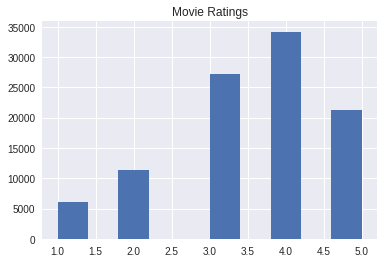

In [11]:
movie_ratings['rating'].hist()
plt.title('Movie Ratings')

In [12]:
num_user = movie_ratings['user_id'].value_counts().reset_index()
num_user.columns= ['user_id','nb_lines']
num_user['nb_lines'].describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: nb_lines, dtype: float64

Total 943 Users, 25% of the Users have rated 33 Movies and 50% of the Users have rated 65 Movies

In [13]:
num_movie = movie_ratings['movie_id'].value_counts().reset_index()
num_movie.columns= ['movie_id','nb_lines']
num_movie['nb_lines'].describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: nb_lines, dtype: float64

Total of 1682 Movies, with 25% of the movies having only 6 ratings and 50% of the movies have only 27 ratings or less.<br>
There is also a movie with 583 rating

In [14]:
num_movie[(num_movie['nb_lines'] == 583)]

,movie_id,nb_lines
0,49,583


Item (Movie) 49 have most ratings. Let's see which movie it is.

In [0]:
names = "movie_id|movie_title|release_date|video_release_date|IMDb|unknown|Action|Adventure|Animation|Children's|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|Musical|Mystery|Romance|Sci-Fi|Thriller|War|Western"

movies = pd.read_csv('ml-100k/u.item', sep = '|', names = names.split('|'), encoding = 'latin-1')

In [0]:
movies['movie_id'] = movies['movie_id'].astype('category').cat.codes.values

In [17]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
movies['movie_title'][(movies['movie_id'] == 49)]

49    Star Wars (1977)
Name: movie_title, dtype: object

Star Wars (1977) have most ratings

## Train-Test Split

  - 80% - Training<br>
  - 20% - Testing

In [0]:
idx, ratings = movie_ratings[['user_id', 'movie_id']], movie_ratings.rating.values

In [0]:
train_idx, test_idx, train_ratings, test_ratings = train_test_split(idx, ratings, test_size = 0.2, random_state = 14)

In [21]:
train_idx.shape, train_ratings.shape

((80000, 2), (80000,))

In [22]:
test_idx.shape, test_ratings.shape

((20000, 2), (20000,))

## Deep Model

In [0]:
num_users = len(movie_ratings.user_id.unique())
num_movies = len(movie_ratings.movie_id.unique())

In [0]:
K.clear_session()

# User Embedding
user_input = Input(shape = [1], name = 'User_Input')
user_embedd = Embedding(num_users+1, 10, name = "User_Embedding")(user_input)
user_flat = Flatten(name = "User_Embedding_Flat")(user_embedd)

# Movie Embedding
movie_input = Input(shape = [1], name = 'Movie_Input')
movie_embedd = Embedding(num_movies+1, 10, name = "Movie_Embedding")(movie_input)
movie_flat = Flatten(name = "Movie_Embedding_Flat")(movie_embedd)

# Concat b/w user & movie
user_movie_concat = Concatenate(name = "User_Movie_Concat")([user_flat, movie_flat])

# Dense
user_movie = Dense(128, activation = 'relu')(user_movie_concat)
user_movie = Dense(64, activation = 'relu')(user_movie)
user_movie = Dense(32, activation = 'relu')(user_movie)
user_movie = Dense(1)(user_movie)

In [26]:
model = Model(inputs = [user_input, movie_input], outputs = user_movie)
model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Movie_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 10)        9440        User_Input[0][0]                 
__________________________________________________________________________________________________
Movie_Embedding (Embedding)     (None, 1, 10)        16830       Movie_Input[0][0]                
__________________________________________________________________________________________________
User_Embed

In [0]:
# Loading the Saved Model
model = load_model('movielens--epoch-5--loss-0.7100--val_loss-0.8145.h5')

In [0]:
# Training
#model.fit(x = [train_idx.user_id, train_idx.movie_id], y = train_ratings, epochs = 5, batch_size = 64, validation_split=0.1)

In [28]:
# RMSE - Root Mean Square Error
# MAE - Mean Absoulte Error

y_pred = model.predict(x = [test_idx.user_id, test_idx.movie_id])
y_true = test_ratings

print ("RMSE: {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
print ("MAE: {}".format(mean_absolute_error(y_true, y_pred)))

RMSE: 0.9350237787189393
MAE: 0.7341826210319996


In [29]:
y_hat = model.predict(x = [movie_ratings.user_id, movie_ratings.movie_id])

print ("RMSE: {}".format(np.sqrt(mean_squared_error(movie_ratings.rating, y_hat))))
print ("MAE: {}".format(mean_absolute_error(movie_ratings.rating, y_hat)))

RMSE: 0.8404887651117902
MAE: 0.6573724255001545


### Testing

In [0]:
test_user = 21

In [0]:
def predict_rating(u_id, m_id):
  return model.predict([np.array([u_id]), np.array([m_id])])[0][0]

In [32]:
user_ratings = movie_ratings[movie_ratings.user_id == test_user].drop('timestamp', axis = 1)
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(test_user, x['movie_id']), axis = 1)
user_ratings.sort_values(by = 'rating', ascending=False).merge(movies[['movie_id', 'movie_title']], on = 'movie_id', how='inner').head(25)

,user_id,movie_id,rating,prediction,movie_title
0,21,201,5,4.650165,Groundhog Day (1993)
1,21,186,5,4.204118,"Godfather: Part II, The (1974)"
2,21,193,5,4.572206,"Sting, The (1973)"
3,21,434,5,4.499319,Butch Cassidy and the Sundance Kid (1969)
4,21,88,5,4.275519,Blade Runner (1982)
5,21,175,5,4.543877,Aliens (1986)
6,21,549,5,3.720581,Die Hard: With a Vengeance (1995)
7,21,3,5,3.965003,Get Shorty (1995)
8,21,84,5,3.362275,"Ref, The (1994)"
9,21,514,5,4.690729,"Boot, Das (1981)"


## End